# Acción 1: Sample y Explore

## Acción 1.1 Cargar el Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = {
    'CustomerID': range(1, 201),
    'Gender': np.random.choice(['Male', 'Female'], 200),
    'Age': np.random.randint(18, 70, 200),
    'Annual Income (k$)': np.random.randint(15, 138, 200),
    'Spending Score (1-100)': np.random.randint(1, 100, 200)
}

# Cargar los datos
df = pd.DataFrame(data)
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
print("\nInformación general del dataset:")
df.info()
print("Primeras 5 filas del dataset:")
print(df.head())

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
Primeras 5 filas del dataset:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16              

## Acción 1.2: Selección de Características Clave
Para la segmentación de clientes, nos centraremos en las variables que miden el valor económico y el comportamiento de compra: Annual Income (k$) e Spending Score (1-100).

In [2]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
print("\nEstadísticas descriptivas de las variables a usar:")
print(X.describe())


Estadísticas descriptivas de las variables a usar:
       Annual Income (k$)  Spending Score (1-100)
count          200.000000              200.000000
mean            60.560000               50.200000
std             26.264721               25.823522
min             15.000000                1.000000
25%             41.500000               34.750000
50%             61.500000               50.000000
75%             78.000000               73.000000
max            137.000000               99.000000


## Acción 1.3: Visualización Inicial (Scatter Plot)
Graficamos para ver si hay outliers y si hay agrupaciones claras antes de aplicar el algoritmo.

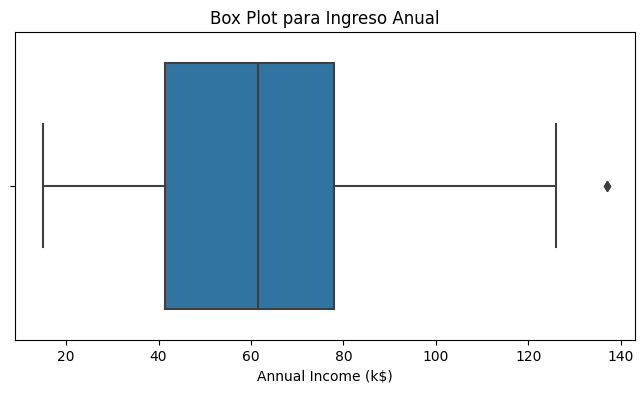

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ejemplo para la variable 'Annual Income (k$)' del dataset de clientes
# Spending score es una variable que varia entre 1 y 100 no es necesario hacer esto.
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Annual Income (k$)'])
plt.title('Box Plot para Ingreso Anual')
plt.show()

In [4]:
# Analizando con el metodo de rango intercuartilico
Q1 = df['Annual Income (k$)'].quantile(0.25)
Q3 = df['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtra y muestra los outliers
outliers_iqr = df[(df['Annual Income (k$)'] < limite_inferior) | (df['Annual Income (k$)'] > limite_superior)]

print(f"\nLímites (IQR): Inferior={limite_inferior:.2f}, Superior={limite_superior:.2f}")
print(f"Número de outliers detectados por IQR: {len(outliers_iqr)}")


Límites (IQR): Inferior=-13.25, Superior=132.75
Número de outliers detectados por IQR: 2


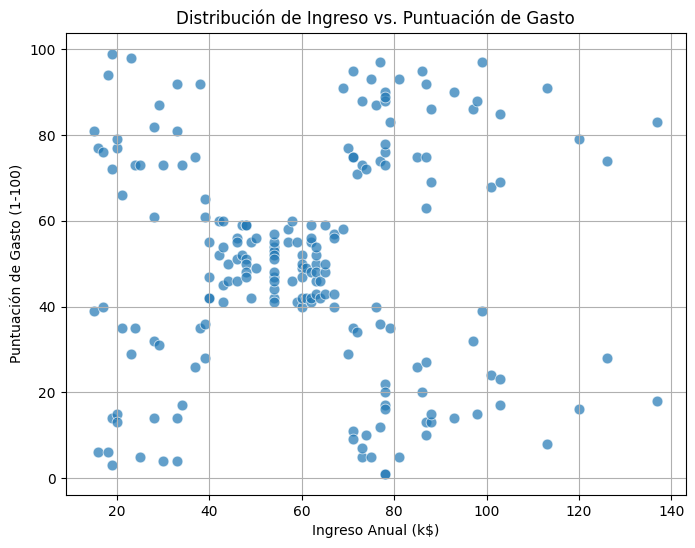

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=X, s=60, alpha=0.7)
plt.title('Distribución de Ingreso vs. Puntuación de Gasto')
plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Puntuación de Gasto (1-100)')
plt.grid(True)
plt.show()

# 2. M - Modify (Modificación/Preparación de Datos)

* Se limitan los outliers mediante el Capping
* K-Means se basa en la distancia euclidiana. Si las variables tienen escalas muy diferentes, la distancia estará dominada por la variable con mayor magnitud. Por ello, el escalado es esencial.

## 2.0 Modificar los Outliers

In [6]:
# Vamos a modificar el dataset suavizando los outliers (Capping)

# 1. Calcular los límites (tal como hicimos en la detección)
Q1 = df['Annual Income (k$)'].quantile(0.25)
Q3 = df['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Límite Inferior (IQR): {limite_inferior:.2f}")
print(f"Límite Superior (IQR): {limite_superior:.2f}")

# 2. Aplicar la Limitación (Capping)
# Creamos una nueva columna para mantener la original intacta (buena práctica)
columna_original = 'Annual Income (k$)'
columna_modificada = 'Income_Capped (k$)'

df[columna_modificada] = df[columna_original]

# Reemplazar valores:
# Si el valor es mayor que el límite superior, se reemplaza por el límite superior.
df.loc[df[columna_original] > limite_superior, columna_modificada] = int(limite_superior)

# Si el valor es menor que el límite inferior, se reemplaza por el límite inferior.
df.loc[df[columna_original] < limite_inferior, columna_modificada] = int(limite_inferior)

# 3. Verificación
print("\nVerificación de los 5 valores más altos (antes vs después):")
# Ordenar para ver los valores extremos
comparacion = df[[columna_original, columna_modificada]].sort_values(
    by=columna_original, ascending=False).head(5)

print(comparacion)

# Si el valor original era mayor que el Límite Superior, el valor modificado será igual a ese límite.

Límite Inferior (IQR): -13.25
Límite Superior (IQR): 132.75

Verificación de los 5 valores más altos (antes vs después):
     Annual Income (k$)  Income_Capped (k$)
199                 137                 132
198                 137                 132
197                 126                 126
196                 126                 126
195                 120                 120


## Acción 2.1: Estandarización de Datos
Aplicamos StandardScaler para que ambas variables tengan media 0 y desviación estándar 1.

In [7]:
scaler = StandardScaler()
# Transformamos la data X
X = df[['Income_Capped (k$)', 'Spending Score (1-100)']]
X_scaled = scaler.fit_transform(X)

print("\nPrimeras filas de los datos escalados (Numpy Array):")
print(X_scaled[:5])


Primeras filas de los datos escalados (Numpy Array):
[[-1.7465265  -0.43480148]
 [-1.7465265   1.19570407]
 [-1.70814973 -1.71591298]
 [-1.70814973  1.04041783]
 [-1.66977297 -0.39597992]]


# 3. 🧠 M - Model (Modelado)

Encontramos el número óptimo de clústeres ($K$) y aplicamos el algoritmo.

## Acción 3.1: Determinar el K Óptimo (Método del Codo)

Ejecutamos K-Means para un rango de valores de $K$ (1 a 10) y registramos la Inercia (Suma de los Cuadrados de las Distancias - WCSS).

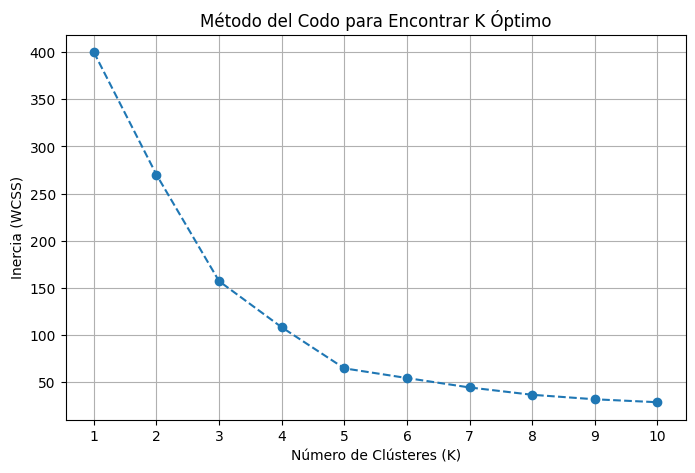

In [8]:
# Lista para almacenar la inercia para cada valor de K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Gráfico del Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Análisis: Al observar el gráfico, se busca el punto donde la curva se "dobla" abruptamente, indicando que añadir más clústeres no reduce significativamente la inercia. Supongamos que el valor óptimo es K=5 (típico para este dataset).

## Acción 3.2: Aplicar K-Means con K Óptimo

Entrenamos el modelo con el número de clústeres seleccionado (e.g., $K=5$).

In [9]:
# Inicializar y entrenar el modelo K-Means con K=5
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Asignar las etiquetas de clústeres al DataFrame original
df['Cluster'] = kmeans.labels_
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Income_Capped (k$),Cluster
0,1,Male,19,15,39,15,2
1,2,Male,21,15,81,15,3
2,3,Female,20,16,6,16,2
3,4,Female,23,16,77,16,3
4,5,Female,31,17,40,17,2


# 4. 📈 A - Assess (Evaluación e Interpretación)

Evaluamos la calidad de la agrupación y la utilidad del modelo.

## Acción 4.1: Métrica de Evaluación (Puntuación de la Silueta)

Calculamos el Silhouette Score. Un valor más cercano a +1 indica una mejor separación y densidad de los clústeres.

In [10]:
# Calcular la puntuación de la Silueta
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])

print(f"\nPuntuación de la Silueta para K={optimal_k}: {silhouette_avg:.4f}")


Puntuación de la Silueta para K=5: 0.5557


## Acción 4.2: Visualización de los Clústeres Finales

Graficamos los datos originales coloreados por la etiqueta del clúster asignado. También revertimos la escala de los centroides para interpretarlos en el contexto de los datos originales.

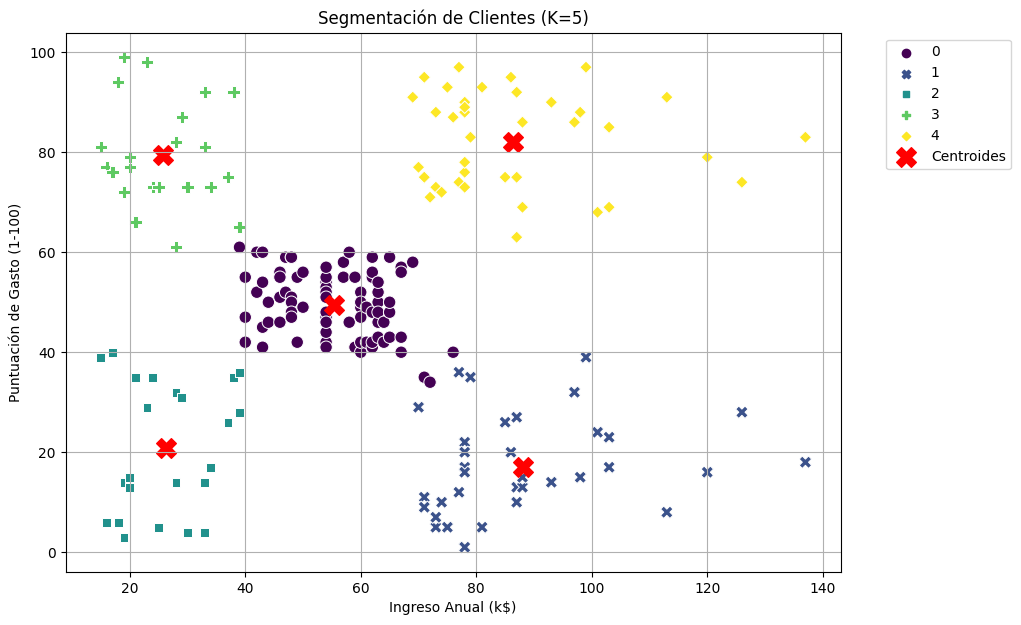

In [11]:
# Centroides en el espacio escalado
centroids_scaled = kmeans.cluster_centers_

# Revertir la escala de los centroides para interpretarlos
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=['Annual Income (k$)', 'Spending Score (1-100)'])

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df,
                palette='viridis', style='Cluster', s=80, legend='full')

# Dibujar los centroides
plt.scatter(centroids_df['Annual Income (k$)'], centroids_df['Spending Score (1-100)'],
            marker='X', s=200, color='red', label='Centroides')

plt.title(f'Segmentación de Clientes (K={optimal_k})')
plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Puntuación de Gasto (1-100)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()

## Acción 4.3: Interpretación de los Clústeres

Analizamos las características de los centroides y los grupos.

In [12]:
print("\nCentroides de los Clústeres (en unidades originales):")
print(centroids_df)


Centroides de los Clústeres (en unidades originales):
   Annual Income (k$)  Spending Score (1-100)
0           55.296296               49.518519
1           88.057143               17.114286
2           26.304348               20.913043
3           25.727273               79.363636
4           86.410256               82.128205


Interpretación de los 5 Clústeres:

Clúster,Ingreso Anual Promedio,Puntuación de Gasto Promedio,Nombre del Segmento (Ejemplo),Estrategia Comercial
0,Medio,Bajo,"Clientes ""Cautelosos""",Fomentar más visitas/gastos con ofertas de bajo riesgo.
1,Bajo,Alto,"Clientes ""Objetivo"" (Gasto impulsivo)",Fidelización con programas de recompensa.
2,Alto,Bajo,"Clientes ""Conservadores""",Ofertas exclusivas de lujo o productos de alto valor.
3,Bajo,Bajo,"Clientes ""Ahorradores""",Ofertas de gran valor y descuentos por volumen.
4,Alto,Alto,Clientes VIP,"Trato personalizado, experiencias y servicios premium."

# 5. 📈 Impacto de $K$: Silueta vs. Inercia

La elección de $K$ es el paso más crítico en K-Means. Para ello, comparamos dos métricas:

1.  **Inercia (WCSS):** Mide la **cohesión interna** del clúster (distancia promedio de los puntos a su centroide). Su valor **siempre disminuye** a medida que $K$ aumenta (más clústeres = puntos más cerca de su centro). El problema es que no penaliza clústeres redundantes o mal separados.
2.  **Puntuación de la Silueta (*Silhouette Score*):** Mide tanto la **cohesión** como la **separación** entre clústeres.
      * Su valor varía entre **-1** y **+1**.
      * Cercano a **+1**: El punto está bien agrupado en su clúster y lejos del clúster vecino. (Deseable)
      * Cercano a **0**: El punto está muy cerca de la frontera entre clústeres.
      * Cercano a **-1**: El punto ha sido asignado al clúster incorrecto.

El valor de $K$ que maximice la **Puntuación de la Silueta** es generalmente el **óptimo**, ya que equilibra la compacidad de los clústeres con su separación.

## Acción 5.1: Análisis de Silueta para Rango de $K$

Calcularemos la Puntuación de la Silueta para $K$ de 2 a 10. No se calcula para $K=1$ porque requiere al menos dos clústeres.

In [13]:
# Rango de K de 2 a 10
K_range = range(2, 11)
silhouette_scores = []
inertia_values = [] # Reutilizamos la inercia para compararla

for k in K_range:
    # 1. Modelar
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    # 2. Evaluar
    # Almacenar Inercia
    inertia_values.append(kmeans.inertia_)
    # Almacenar Puntuación de la Silueta
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

print("Resultados de Evaluación:")
for k, score, wcss in zip(K_range, silhouette_scores, inertia_values):
    print(f"K={k}: Silueta = {score:.4f}, Inercia = {wcss:.2f}")

Resultados de Evaluación:
K=2: Silueta = 0.2949, Inercia = 270.05
K=3: Silueta = 0.4672, Inercia = 157.11
K=4: Silueta = 0.4946, Inercia = 108.18
K=5: Silueta = 0.5557, Inercia = 64.63
K=6: Silueta = 0.5406, Inercia = 54.34
K=7: Silueta = 0.5279, Inercia = 44.35
K=8: Silueta = 0.4576, Inercia = 36.58
K=9: Silueta = 0.4565, Inercia = 31.81
K=10: Silueta = 0.4424, Inercia = 28.69


## Acción 5.2: Visualización de las Métricas

Visualizaremos ambas métricas para determinar el $K$ ideal.

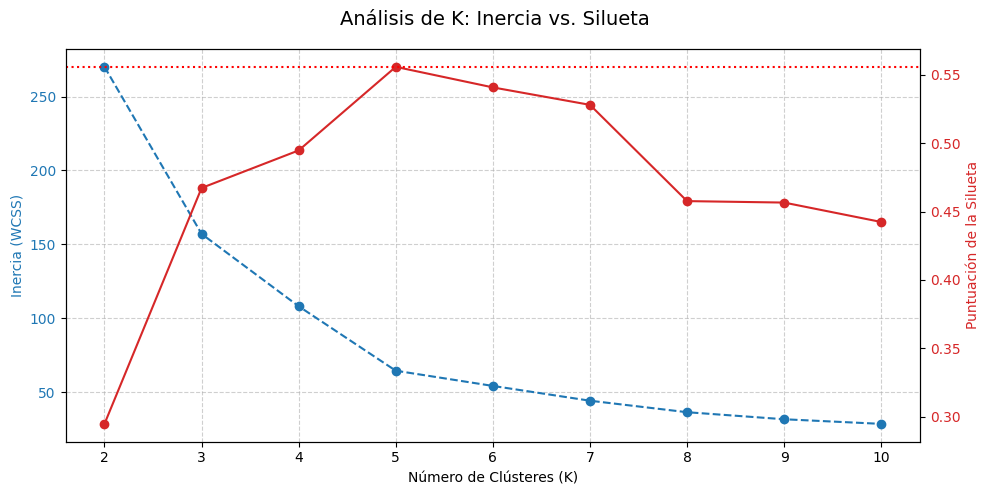

In [14]:
# Crear figura con dos subgráficos
fig, ax1 = plt.subplots(figsize=(10, 5))

# Gráfico de la Inercia (Método del Codo)
color = 'tab:blue'
ax1.set_xlabel('Número de Clústeres (K)')
ax1.set_ylabel('Inercia (WCSS)', color=color)
ax1.plot(K_range, inertia_values, marker='o', linestyle='--', color=color, label='Inercia')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Crear un segundo eje Y para la Puntuación de la Silueta
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Puntuación de la Silueta', color=color)
ax2.plot(K_range, silhouette_scores, marker='o', linestyle='-', color=color, label='Silueta')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=np.max(silhouette_scores), color='red', linestyle=':', label='Máx. Silueta')

# Título y Mostrar
fig.suptitle('Análisis de K: Inercia vs. Silueta', fontsize=14)
fig.tight_layout()
plt.xticks(K_range)
plt.show()


### 💡 Conclusión del Análisis de $K$

Al analizar la gráfica y los resultados numéricos:

1.  **Inercia (WCSS):** La Inercia muestra una curva descendente clara. El **"codo"** más pronunciado (donde la pendiente cambia más drásticamente) ocurre típicamente en **$K=5$** (o a veces $K=4$).
2.  **Silueta:** Buscamos el **pico** más alto en la línea de Silueta.
      * Si el valor más alto de Silueta coincide con el "codo" de la Inercia, como suele ocurrir en **$K=5$**, esto nos da una fuerte confirmación.
      * Si la Silueta fuera máxima en $K=2$ o $K=3$, pero la Inercia sigue siendo muy alta, podríamos preferir un $K$ mayor que ofrezca un mejor balance, siempre y cuando la Silueta no sea demasiado baja (idealmente $ > 0.5$).

**Decisión Final:** Basado en la convergencia de ambas métricas para este tipo de *dataset* (donde $K=5$ revela grupos interpretablemente distintos: VIP, Conservadores, Objetivos, etc.), **$K=5$** se confirma como el número óptimo de clústeres para la segmentación.